In [3]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [4]:
data = pd.read_csv('./211104/211104 kepsh1.csv', parse_dates = True)

In [5]:
data

,DateTime,Room_Temp(�C),T1(�C),T2(�C),T3(�C),T4(�C),T5(�C),T6(�C),T8(�C),T9(�C),...,Pvt_Supply(W),Pv_Supply(W),Heatpump_Load(W),FuelCell_Supply(W),WS_Temperature(�C),WS_SolarRadiation(w/m�),WS_WindDirection_Slope(w/m�),Thermal_Operation_Mode,Total_Consumption(W),Total_Production(W)
0,2021-04-27 10:59:00,25.80,39.7642,38.9047,30.2405,29.2547,30.6289,23.8826,21.1263,43.1663,...,-9.0,5400.0,249.0,0.0,19.0,415.9,424.842,NaN,0,0
1,2021-04-27 11:00:00,25.80,40.1910,39.9168,30.2350,29.2187,30.5723,23.7865,21.1465,43.1815,...,-9.0,5655.0,274.0,0.0,19.0,415.9,437.187,NaN,0,0
2,2021-04-27 11:01:00,25.80,46.5653,40.5658,30.2460,29.1893,30.5332,23.6677,21.1420,43.1830,...,-9.0,5777.0,276.0,0.0,19.0,415.9,455.580,NaN,0,0
3,2021-04-27 11:02:00,25.80,49.1767,42.5260,30.2463,29.1720,30.5095,23.6100,21.1353,43.1763,...,-9.0,6116.0,276.0,0.0,19.0,415.9,493.072,NaN,0,0
4,2021-04-27 11:03:00,25.80,46.0035,44.3658,30.2517,29.1640,30.4855,23.5548,21.1123,43.1638,...,-9.0,5049.0,276.0,0.0,19.0,415.9,410.092,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224874,2021-11-04 16:24:00,26.70,44.6310,39.6540,30.6040,29.2290,29.8980,100.0000,19.7600,51.4850,...,183.0,959.0,29.0,374.0,17.0,13.4,82.673,0.0,635,1516
224875,2021-11-04 16:25:00,26.70,44.5840,39.5610,30.5810,29.2070,29.8790,100.0000,19.7520,51.4730,...,174.0,912.0,29.0,374.0,17.0,13.4,78.300,0.0,634,1460
224876,2021-11-04 16:26:00,26.70,44.4540,39.4660,30.5750,29.2010,29.8740,100.0000,19.7520,51.4760,...,167.0,874.0,29.0,374.0,17.0,13.4,74.750,0.0,634,1415
224877,2021-11-04 16:27:00,26.70,44.3810,39.3810,30.5520,29.1830,29.8660,100.0000,19.7520,51.4840,...,161.0,848.0,29.0,375.0,17.0,13.4,72.533,0.0,1423,1384


In [6]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'Room_Temp(�C)', 'T1(�C)', 'T2(�C)', 'T3(�C)', 'T4(�C)', 'T5(�C)', 'T6(�C)', 'T8(�C)', 'T9(�C)', 'T10(�C)', 'T12(�C)', 'F1(lpm)', 'F2(lpm)', 'F3(lpm)', 'F4(lpm)', 'ESS_Power(W)', 'Pvt_Supply(W)', 'Pv_Supply(W)', 'Heatpump_Load(W)', 'FuelCell_Supply(W)', 'WS_Temperature(�C)', 'WS_SolarRadiation(w/m�)', 'WS_WindDirection_Slope(w/m�)', 'Thermal_Operation_Mode', 'Total_Consumption(W)', 'Total_Production(W)']


In [7]:
df_kepsh1 = pd.DataFrame()
df_kepsh1['Time'] = data['DateTime']
df_kepsh1['PV_kepsh1(W)'] = data['Pv_Supply(W)']
df_kepsh1['PVT_kepsh1(W)'] = data['Pvt_Supply(W)']
df_kepsh1['Slope_solar_radiation(w/m2)'] = data['WS_WindDirection_Slope(w/m�)']
df_kepsh1['FC(W)'] = data['FuelCell_Supply(W)']
df_kepsh1['HP_kepsh1(W)'] = data['Heatpump_Load(W)']
df_kepsh1['Cons_kepsh1(W)'] = data['Total_Consumption(W)']
df_kepsh1['Prod_kepsh1(W)'] = data['Total_Production(W)']

df_kepsh1.head()


,Time,PV_kepsh1(W),PVT_kepsh1(W),Slope_solar_radiation(w/m2),FC(W),HP_kepsh1(W),Cons_kepsh1(W),Prod_kepsh1(W)
0,2021-04-27 10:59:00,5400.0,-9.0,424.842,0.0,249.0,0,0
1,2021-04-27 11:00:00,5655.0,-9.0,437.187,0.0,274.0,0,0
2,2021-04-27 11:01:00,5777.0,-9.0,455.580,0.0,276.0,0,0
3,2021-04-27 11:02:00,6116.0,-9.0,493.072,0.0,276.0,0,0
4,2021-04-27 11:03:00,5049.0,-9.0,410.092,0.0,276.0,0,0


In [8]:
df_kepsh1 = df_kepsh1[df_kepsh1['Cons_kepsh1(W)']< 10000]

In [9]:
df_kepsh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224878 entries, 0 to 224878
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Time                         224878 non-null  object 
 1   PV_kepsh1(W)                 224482 non-null  float64
 2   PVT_kepsh1(W)                224482 non-null  float64
 3   Slope_solar_radiation(w/m2)  224482 non-null  float64
 4   FC(W)                        224482 non-null  float64
 5   HP_kepsh1(W)                 224482 non-null  float64
 6   Cons_kepsh1(W)               224878 non-null  int64  
 7   Prod_kepsh1(W)               224878 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 15.4+ MB


In [10]:
df_kepsh1['Cons_kepsh1(W)'] = df_kepsh1['Cons_kepsh1(W)'].astype(float)
df_kepsh1['Prod_kepsh1(W)'] = df_kepsh1['Prod_kepsh1(W)'].astype(float)

In [11]:
df_kepsh1['Cons_acc_kepsh1(Wh)'] = df_kepsh1['Cons_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['Prod_acc_kepsh1(Wh)'] = df_kepsh1['Prod_kepsh1(W)'].cumsum()*60/3600

In [12]:
df_kepsh1['denominator'] = df_kepsh1.loc[:,['Cons_kepsh1(W)','Prod_kepsh1(W)']].min(axis=1)
df_kepsh1['denominator_acc'] = df_kepsh1.loc[:,['Cons_acc_kepsh1(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [13]:
df_kepsh1['SCF'] = df_kepsh1['denominator']/df_kepsh1['Prod_kepsh1(W)']
df_kepsh1['LCF'] = df_kepsh1['denominator']/df_kepsh1['Cons_kepsh1(W)']

In [15]:
df_kepsh1['SCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Prod_acc_kepsh1(Wh)']
df_kepsh1['LCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['self_sustain'] = df_kepsh1['Prod_acc_kepsh1(Wh)']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['Avg_SCF&LCF'] = (df_kepsh1['SCF_acc']+df_kepsh1['LCF_acc'])/2

In [16]:
df_kepsh1['Time'] = pd.to_datetime(df_kepsh1['Time'])

In [17]:
df_kepsh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224878 entries, 0 to 224878
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Time                         224878 non-null  datetime64[ns]
 1   PV_kepsh1(W)                 224482 non-null  float64       
 2   PVT_kepsh1(W)                224482 non-null  float64       
 3   Slope_solar_radiation(w/m2)  224482 non-null  float64       
 4   FC(W)                        224482 non-null  float64       
 5   HP_kepsh1(W)                 224482 non-null  float64       
 6   Cons_kepsh1(W)               224878 non-null  float64       
 7   Prod_kepsh1(W)               224878 non-null  float64       
 8   Cons_acc_kepsh1(Wh)          224878 non-null  float64       
 9   Prod_acc_kepsh1(Wh)          224878 non-null  float64       
 10  denominator                  224878 non-null  float64       
 11  denominator_acc           

In [18]:
df_kepsh1.to_csv('./211104_kepsh1.csv')

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


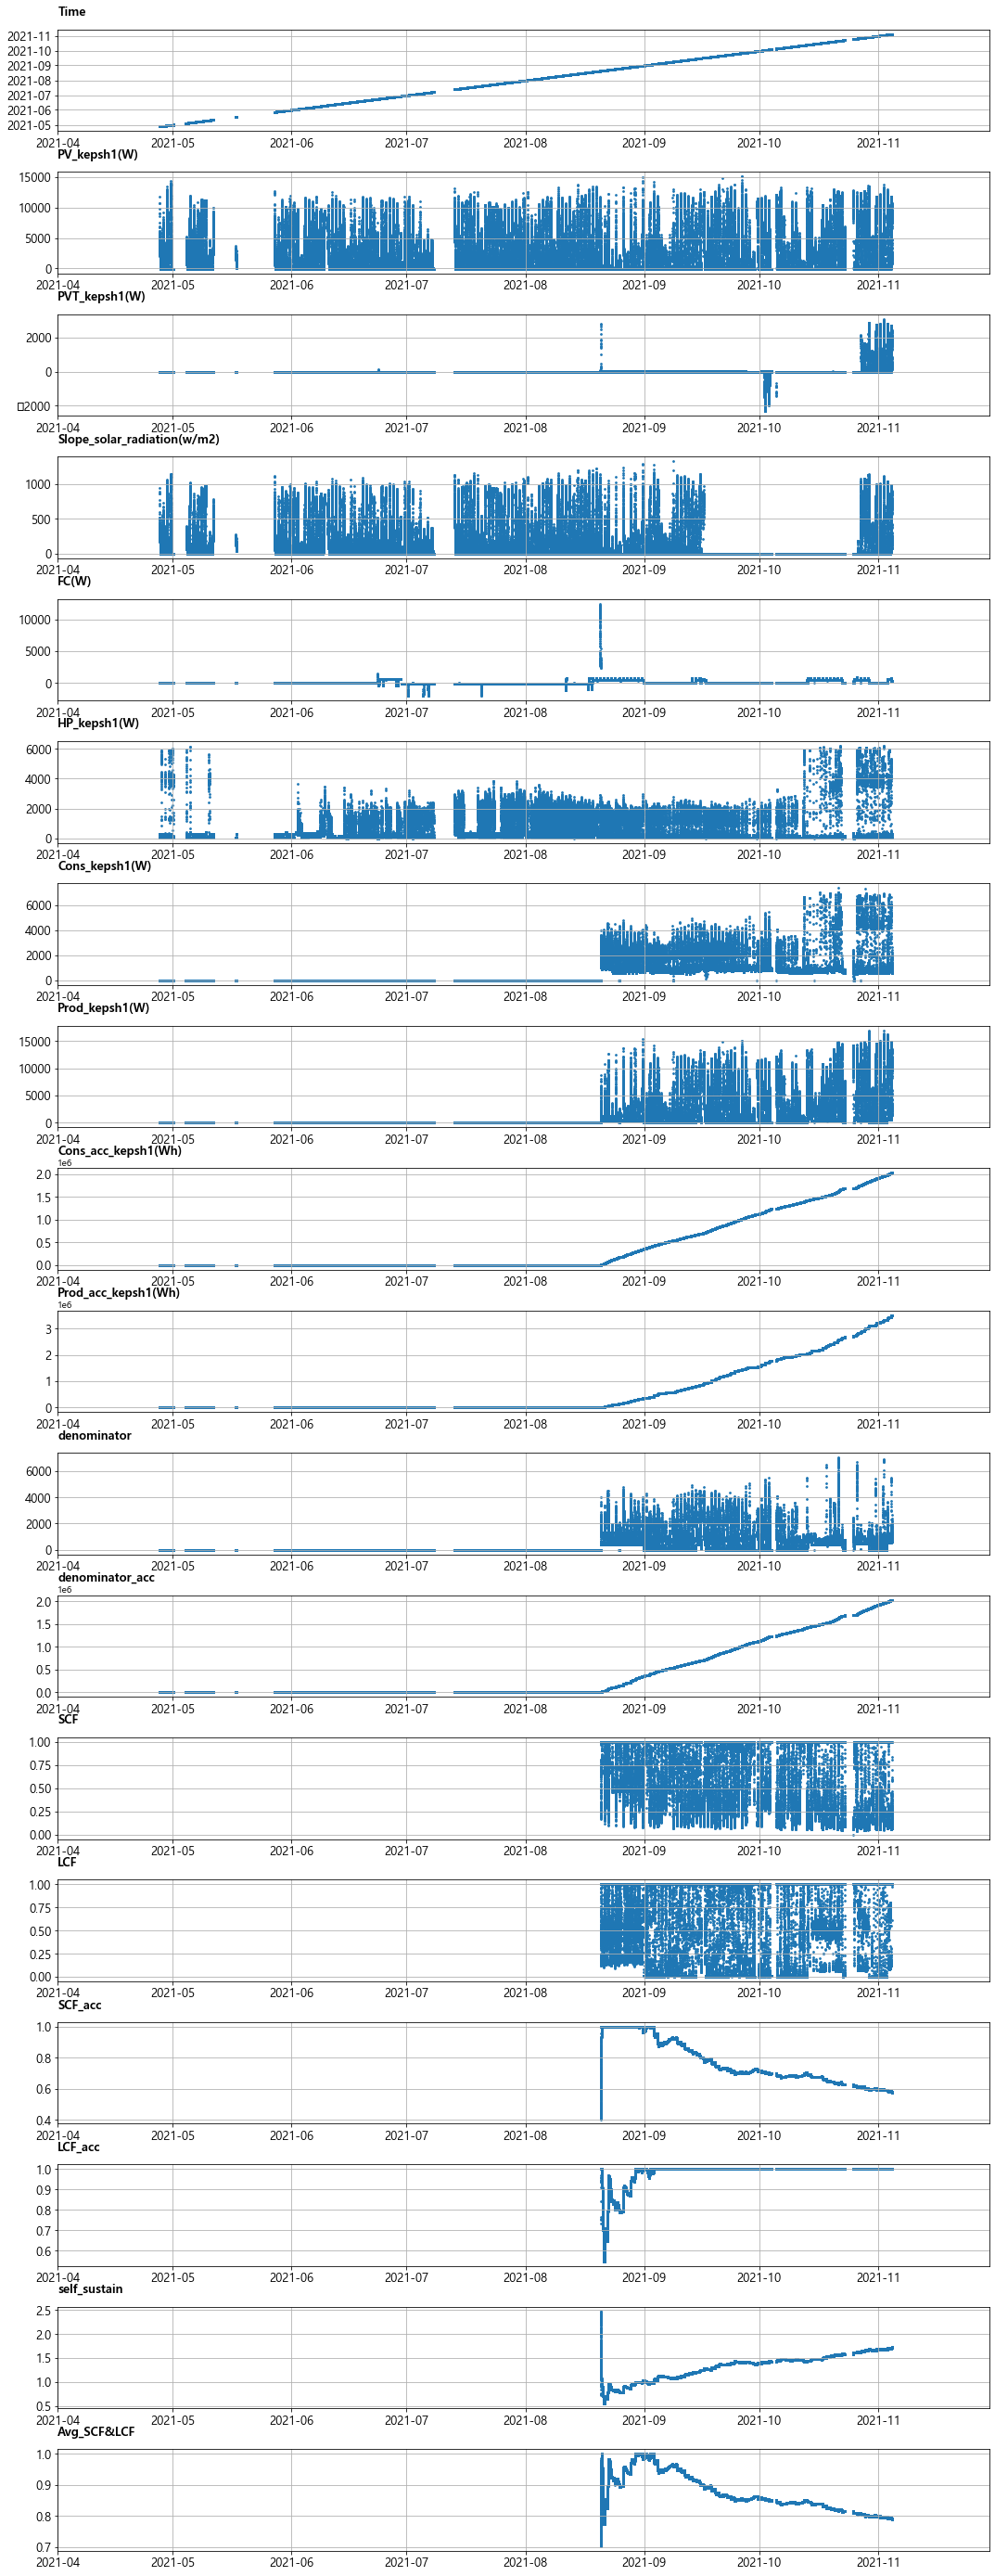

In [19]:
fig, ax = plt.subplots(figsize=(18,50))


for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kepsh1.columns[i]
    plt.scatter(x=df_kepsh1['Time'], y=df_kepsh1[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()